In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
from msdm.domains.gridgame.tabulargridgame import TabularGridGame
from msdm.domains.gridworld.mdp import GridWorld
from msdm.algorithms.multiagentqlearning import TabularMultiAgentQLearner
from msdm.algorithms.friendfoeq import FriendFoeQ
from msdm.algorithms.correlatedq import CorrelatedQLearner
from msdm.algorithms.nashq import NashQLearner
from msdm.core.problemclasses.stochasticgame.policy.tabularpolicy import SingleAgentPolicy
from msdm.core.assignment.assignmentmap import AssignmentMap
import msdm
import numpy as np
import importlib
import itertools
import IPython.display as display

In [6]:
three_player_gamestring = """
# # # # # # # 
# A1 . A2 . A0 #
# . . . . . # 
# G1 . G2 . G0 #
# # # # # # #  
""".strip()

two_player = """
# # # # #
# . G . # 
# . . . #
# A0.~ . A1.~ #
# # # # #
"""
# gg = TabularGridGame(three_player_gamestring,agent_symbols=("A0","A1","A2"),goal_symbols=(
#                      ("G0", ("A0", )),
#                      ("G1", ("A1", )),
#                      ("G2",("A2", )),
#                      ("G", ("A0", "A1"))),)
gg = TabularGridGame(two_player,agent_symbols=("A0","A1"),goal_symbols=(("G",("A0","A1")),),step_cost=0,collision_cost=-1,goal_reward=100)
gg.state_list
print("State list generated")

State list generated


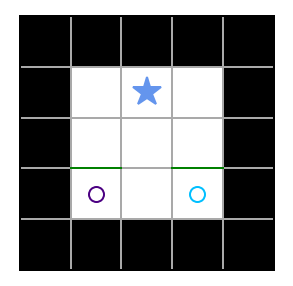

In [8]:
gg.plot() # ~ is a fence above

In [9]:
random_policy = AssignmentMap()
for state in gg.state_list:
    actions = list(gg.joint_actions(state)["A1"])
    random_policy[state] = AssignmentMap()
    for action in actions:
        random_policy[state][action] = 1.0/len(actions)
random_policy = SingleAgentPolicy("A1",gg,random_policy)

In [14]:
len(gg.state_list)
random_policy.policy_matrix.shape

74

In [15]:
random_policy.policy_matrix[0] # policy_matrix is |S| x |A|

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [24]:
random_policy.action_dist(gg.state_list[0]) # action_dist is |S| x |A|
# five acitons here for each state, up, down, left, right, stay

DiscreteFactorTable({{'x': 0, 'y': 0}: -1.61, {'x': 1, 'y': 0}: -1.61, {'x': -1, 'y': 0}: -1.61, {'x': 0, 'y': 1}: -1.61, {'x': 0, 'y': -1}: -1.61})

In [45]:
all_agents = ["A0","A1"]
learning_agents = ["A0","A1"]
friends = {"A1":[],"A0":[]}
foes = {"A1":["A0"],"A0":["A1"]}
# other_policies = {"A0":random_policy}
other_policies = {}
params = {"num_episodes":5000,"epsilon":.01,"epsilon_decay":1.0,"discount_rate":.99,
          "learning_rate":0.01,"show_progress":True,"render":False,"render_from":0,"default_q_value":1.0,
          }

In [46]:
q_learner = TabularMultiAgentQLearner(learning_agents,other_policies,all_actions=True,alg_name="Q-Learning",**params)
ffq_learner = FriendFoeQ(learning_agents,friends,foes,other_policies,alg_name="FFQ-Learning",**params)
libertarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Libertarian",alg_name="Libertarian CEQ",**params)
# utilitarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Utilitarian",alg_name="Utilitarian CEQ",**params)
# republican_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Republican",alg_name="Republican CEQ",**params)
# egalitarian_q_learner = CorrelatedQLearner(learning_agents,other_policies,objective_func="Egalitarian",alg_name="Egalitarian CEQ",**params)
# nash_q_learner = NashQLearner(learning_agents,other_policies,alg_name="Nash-Q Learning",**params)
# algorithms = [q_learner,ffq_learner,utilitarian_q_learner,republican_q_learner,egalitarian_q_learner,libertarian_q_learner,nash_q_learner]
# algorithms = [q_learner,ffq_learner,utilitarian_q_learner,republican_q_learner,egalitarian_q_learner,libertarian_q_learner]
# algorithms = [ffq_learner]
algorithms = [q_learner,ffq_learner,libertarian_q_learner] # working for now

Error message for nash_q_learner

```text
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/Users/kesong/Documents/git-personal/pomdp-work/MultiAgentQLearning.ipynb Cell 11 in <cell line: 3>()
      2 example_trajectories = []
      3 for alg in algorithms:
----> 4     res = alg.plan_on(gg, delta=10) # KC change
      5     results.append(res)
      6     trajectory = res.pi.run_on(gg,maxSteps=10)

File ~/miniconda3/envs/msdm/lib/python3.9/site-packages/msdm/algorithms/multiagentqlearning.py:214, in TabularMultiAgentQLearner.plan_on(self, problem, delta)
    212     rewards = problem.joint_rewards(state,action,next_state)
    213     for agent in self.learning_agents:
--> 214         new_q = self.update(agent,action,res.Q,rewards,state,next_state,problem)
    215         next_vals[agent] += prob*new_q
    216 for agent in self.learning_agents:

File ~/miniconda3/envs/msdm/lib/python3.9/site-packages/msdm/algorithms/nashq.py:51, in NashQLearner.update(self, agent_name, actions, q_values, joint_rewards, curr_state, next_state, problem)
     49     warnings.simplefilter("ignore")
     50     eqs = list(game.support_enumeration())
---> 51 rand_eq = np.random.choice(len(eqs))
     52 rand_eq = eqs[rand_eq]
     53 q_val_updates = AssignmentMap()

File mtrand.pyx:909, in numpy.random.mtrand.RandomState.choice()

ValueError: a must be greater than 0 unless no samples are taken
```

In [47]:
results = []
example_trajectories = []
for alg in algorithms:
    res = alg.plan_on(gg, delta=10) # KC change
    results.append(res)
    trajectory = res.pi.run_on(gg,maxSteps=10)
    example_trajectories.append(trajectory)

100%|██████████| 74/74 [00:00<00:00, 157.61it/s]


{'A0': 99.98998990090003, 'A1': 99.9899899009}


100%|██████████| 74/74 [00:00<00:00, 161.45it/s]


{'A0': 98.99009000189103, 'A1': 98.9900900018909}


100%|██████████| 74/74 [00:00<00:00, 166.63it/s]


{'A0': 98.00017920374523, 'A1': 98.00017920374508}


100%|██████████| 74/74 [00:00<00:00, 167.01it/s]


{'A0': 97.02016761256311, 'A1': 0.9702795941170308}


100%|██████████| 74/74 [00:00<00:00, 167.93it/s]


{'A0': 23.535082450139186, 'A1': 0.9605671924078933}


100%|██████████| 74/74 [00:00<00:00, 166.78it/s]


{'A0': 0.4754902697852543, 'A1': 0.4754925875672029}
Planning for Q-Learning Complete


100%|██████████| 74/74 [00:11<00:00,  6.22it/s]


{'A0': 98.99900000719309, 'A1': 98.99900000718966}


100%|██████████| 74/74 [00:12<00:00,  6.07it/s]


{'A0': 4.6373849177202254e-07, 'A1': 3.1407328527843673e-06}
Planning for FFQ-Learning Complete


100%|██████████| 74/74 [00:19<00:00,  3.74it/s]


{'A0': 99.98998990195757, 'A1': 99.98998990094972}


100%|██████████| 74/74 [00:21<00:00,  3.37it/s]


{'A0': 98.99009077229769, 'A1': 98.99009063288479}


100%|██████████| 74/74 [00:22<00:00,  3.32it/s]


{'A0': 98.00016984186034, 'A1': 97.99968506311637}


100%|██████████| 74/74 [00:21<00:00,  3.38it/s]


{'A0': 84.27842737861782, 'A1': 48.018097401294106}


100%|██████████| 74/74 [00:22<00:00,  3.33it/s]


{'A0': 64.75742942252066, 'A1': 16.906093494725894}


100%|██████████| 74/74 [00:22<00:00,  3.25it/s]


{'A0': 63.11023482052439, 'A1': 17.877605206527548}


100%|██████████| 74/74 [00:22<00:00,  3.26it/s]


{'A0': 74.53573729624026, 'A1': 63.436091406100495}


100%|██████████| 74/74 [00:22<00:00,  3.32it/s]


{'A0': 66.84761817794525, 'A1': 62.88426991861783}


100%|██████████| 74/74 [00:21<00:00,  3.40it/s]


{'A0': 67.32634608581144, 'A1': 77.6498165674323}


100%|██████████| 74/74 [00:23<00:00,  3.21it/s]


{'A0': 54.6748694905394, 'A1': 74.49276677425256}


100%|██████████| 74/74 [00:22<00:00,  3.34it/s]


{'A0': 47.19373430393031, 'A1': 75.56408473736026}


100%|██████████| 74/74 [00:22<00:00,  3.35it/s]


{'A0': 39.75867845953631, 'A1': 63.05220035382046}


100%|██████████| 74/74 [00:21<00:00,  3.38it/s]


{'A0': 25.522465165146812, 'A1': 68.99851356112549}


100%|██████████| 74/74 [00:21<00:00,  3.43it/s]


{'A0': 18.146475256637444, 'A1': 32.14533117911046}


100%|██████████| 74/74 [00:21<00:00,  3.42it/s]


{'A0': 28.35047964278125, 'A1': 28.537700988501}


100%|██████████| 74/74 [00:21<00:00,  3.43it/s]


{'A0': 20.098269336370066, 'A1': 10.07403256678839}


100%|██████████| 74/74 [00:21<00:00,  3.42it/s]


{'A0': 10.497669880575437, 'A1': 10.7311068304368}


100%|██████████| 74/74 [00:21<00:00,  3.43it/s]


{'A0': 38.53623189062783, 'A1': 9.297714816645055}


100%|██████████| 74/74 [00:21<00:00,  3.44it/s]


{'A0': 49.26253430481126, 'A1': 7.078890457679492}


100%|██████████| 74/74 [00:21<00:00,  3.42it/s]


{'A0': 15.54126754760771, 'A1': 8.909663971683827}


100%|██████████| 74/74 [00:21<00:00,  3.43it/s]


{'A0': 11.726238548515894, 'A1': 8.201077965849692}


100%|██████████| 74/74 [00:21<00:00,  3.40it/s]


{'A0': 30.872300842719312, 'A1': 8.317907757964804}


100%|██████████| 74/74 [00:21<00:00,  3.38it/s]


{'A0': 10.757279402443743, 'A1': 10.108736817836729}


100%|██████████| 74/74 [00:21<00:00,  3.42it/s]


{'A0': 7.886605691857071, 'A1': 8.696371666928457}
Planning for Libertarian CEQ Complete


 30%|██▉       | 22/74 [01:16<03:00,  3.48s/it]


ValueError: a must be greater than 0 unless no samples are taken

In [54]:
algorithms = algorithms[:-1] # remove nash q learner

Calculating Projected Q-Values: 100%|██████████| 74/74 [00:00<00:00, 8209.55it/s]


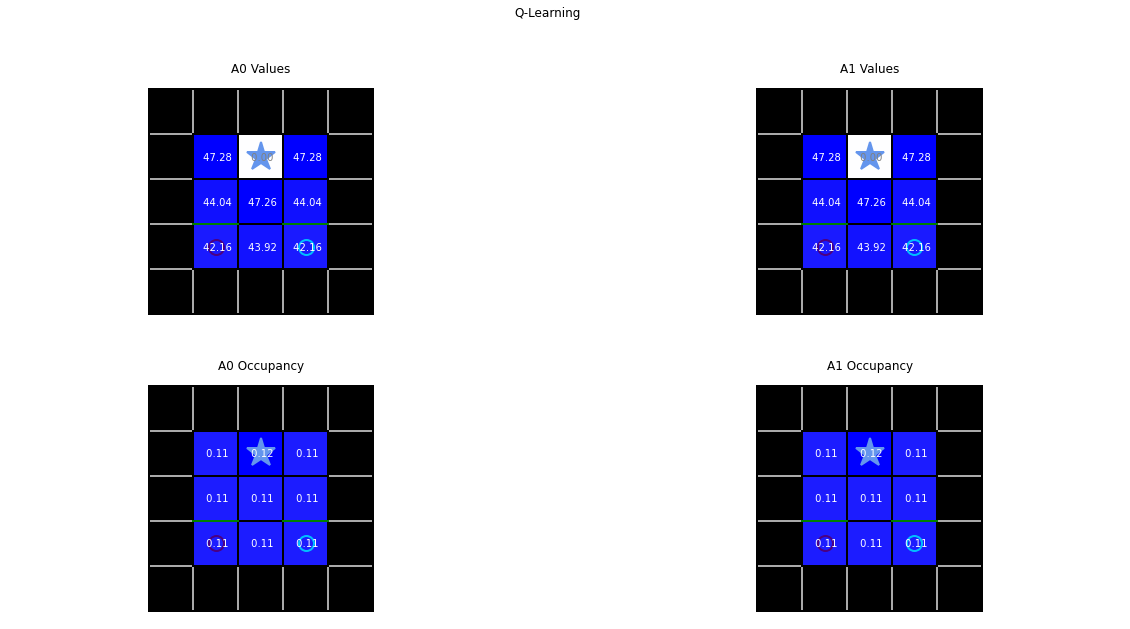

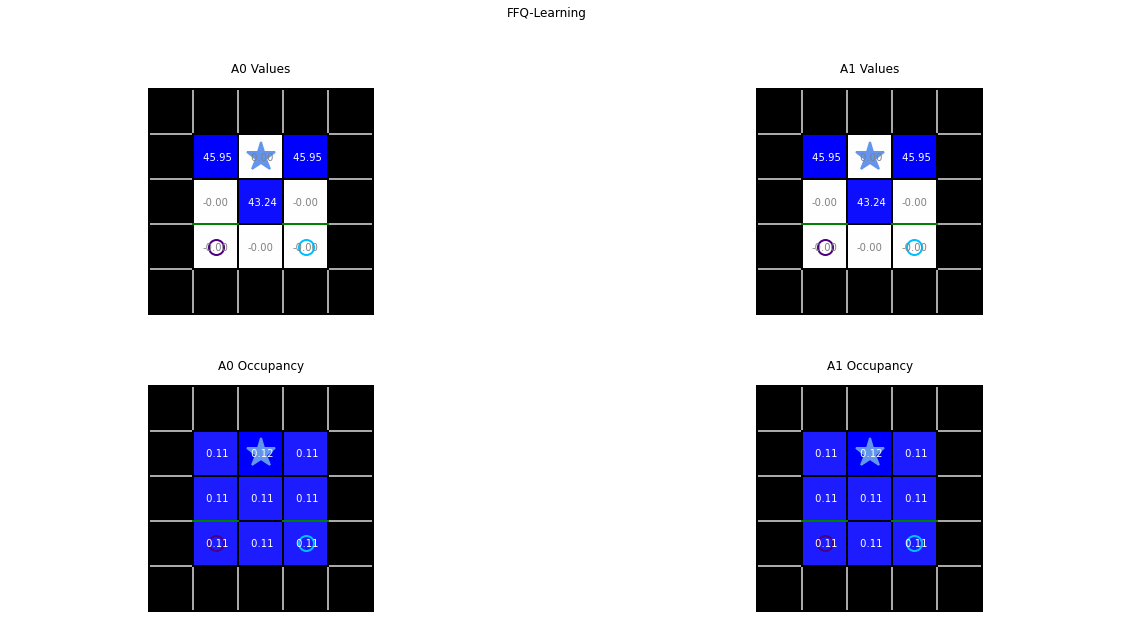

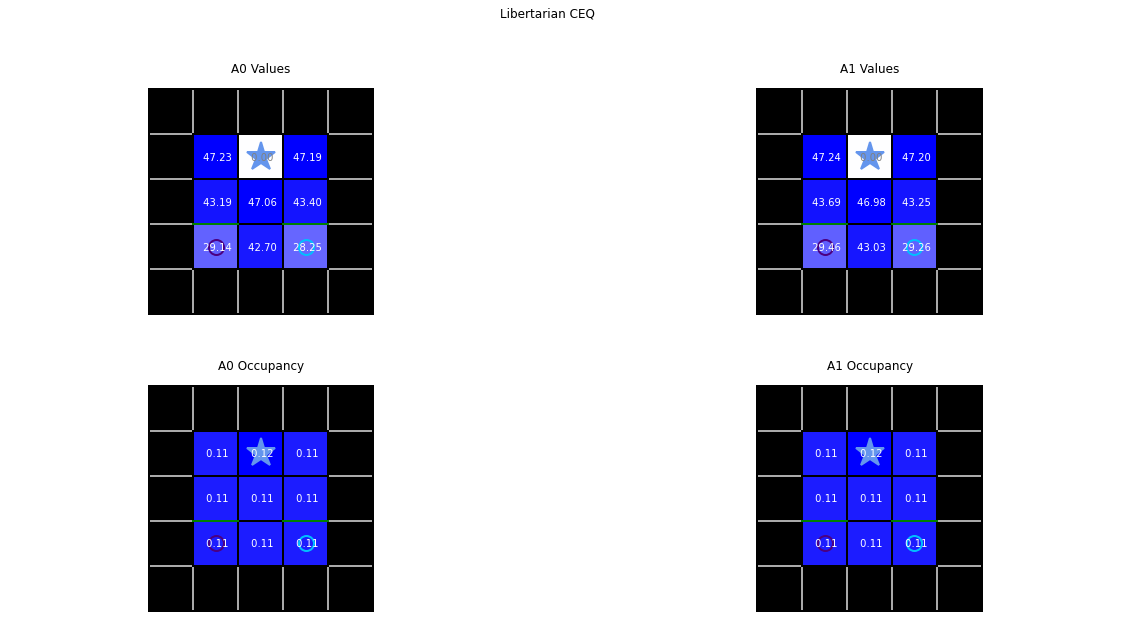

In [55]:
for k,alg in enumerate(algorithms): 
    fig,axes = plt.subplots(2,len(all_agents),figsize=(20,10))
    fig.suptitle(alg.alg_name)
    for i,agent_name in enumerate(all_agents):
        plotter = gg.plot(ax=axes[0][i])
        plotter.title(agent_name + " Values")
        q_matrix = results[k].pi.single_agent_policies[agent_name].q_matrix
        occupancy_matrix = results[k].pi.occupancy_matrix
        occupancy_matrix.fill(1.0/len(occupancy_matrix[0]))
        initial_state = gg.initial_state_dist().sample()
        initial_index = gg.state_list.index(initial_state)
#         plotter.plot_state_action_map(results[k].pi.positionActionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter.plot_state_map(results[k].pi.positionMapping(agent_name,q_matrix,occupancy_matrix,initial_state))
        plotter = gg.plot(ax=axes[1][i])
        plotter.title(agent_name + " Occupancy")
        plotter.plot_weights(results[k].pi.weightMapping(agent_name,occupancy_matrix,initial_state))

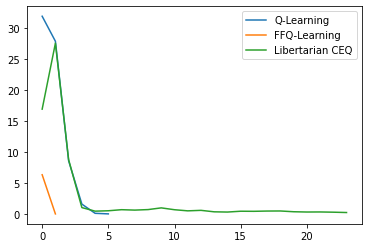

In [58]:
for k,alg in enumerate(algorithms): 
    plt.plot(alg.errors, label=alg.alg_name)
plt.legend()